# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1KRQWUflRd73UtlVAnpBdQ5xJvJOXSpFo

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install torchtext==0.6

In [ ]:
import torchtext
from torchtext.data import Field

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/sms+spam+collection.zip', 'r')
zip_ref.extractall('/')
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
ham_count = 0
spam_count = 0

with open('/SMSSpamCollection') as file:
    for line in file:
        if line.startswith('spam') and spam_count < 1:
            print(line)
            spam_count += 1
        if line.startswith('ham') and ham_count < 1:
            print(line)
            ham_count += 1
        if spam_count >= 1 and ham_count >= 1:
            break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



After displaying multiple lines in the collection, I observe that non-spam messages are labelled with 'ham', and spam messages are labelled with 'spam'.

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam_count = 0
ham_count = 0
with open('/SMSSpamCollection') as file:
    for line in file:
        if line.startswith('spam'):
            spam_count += 1
        if line.startswith('ham'):
            ham_count += 1
print('Number of spam messages: ', spam_count)
print('Number of non-spam messages: ', ham_count)

Number of spam messages:  747
Number of non-spam messages:  4827


There are 747 spam messages and 4827 non-spam messages.

### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages: \\
    - Can capture more subtle relationships/features in the text such as grammar, punctuation, spelling etc. \\
    - Can handle typos and misspelled words, as there is no predifined list/set of words used in a word level RNN \\
Disadvantages: \\
    - More computation required/more complex model required, as sequences are much longer at the character level compared to the word level. \\
    - Can lead to poorer performance compared to word level RNN because it needs to recognize that a combination of letters form a specific word, which carries a certain sentiment in context, rather than using a word level RNN which has the entire word fed into the model beforehand. \\

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
def preprocess_label(label):
    return int(label == 'spam')

text_field = torchtext.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  lower=True,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True)
label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=preprocess_label)

fields = [('label', label_field), ('sms', text_field)]
data = torchtext.data.TabularDataset("/SMSSpamCollection", "tsv", fields)

np.random.seed(0)
train, valid, test = data.split(split_ratio=[0.6,0.2,0.2])

print(data[0].sms)
print(data[0].label)
print()
print(data[2].sms)
print(data[2].label)

go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...
0

free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's
1


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

Having a balanced train set is crucial because the model will learn the labels in the train set, and will pick up on the fact that there is more non-spam than spam. This bias will lead to the model predicting non-spam much more often than spam, simply because it is more likely that any given sample is a non spam message. for example, if 90% of messages were non spam, the model can just predict non-spam for every single example and can achieve 90% accuracy.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)

In [ ]:
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7a08622b74f0>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             'c': 13,
             'h': 14,
             'd': 15,
             'm': 16,
             '0': 17,
             'y': 18,
             'w': 19,
             '.': 20,
             'p': 21,
             'g': 22,
             'f': 23,
             'b': 24,
             '1': 25,
             'k': 26,
             '2': 27,
             '8': 28,
             'v': 29,
             '5': 30,
             'x': 31,
             '4': 32,
             '7': 33,
             '3': 34,
             '6': 35,
             '!': 36,
             '9': 37,
             ',': 38,
             '/': 39,
             "'":

In [ ]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'c',
 'h',
 'd',
 'm',
 '0',
 'y',
 'w',
 '.',
 'p',
 'g',
 'f',
 'b',
 '1',
 'k',
 '2',
 '8',
 'v',
 '5',
 'x',
 '4',
 '7',
 '3',
 '6',
 '!',
 '9',
 ',',
 '/',
 "'",
 '?',
 '-',
 '£',
 'j',
 '&',
 ':',
 'z',
 ';',
 '*',
 ')',
 '+',
 'q',
 '"',
 '(',
 '#',
 '>',
 'ü',
 '=',
 '@',
 '$',
 '\x92',
 '_',
 '<',
 '|',
 '‘',
 '%',
 '“',
 '\x93',
 '’',
 '…',
 '–',
 '\\',
 '\x96',
 '\t',
 '\n',
 '[',
 ']',
 '~',
 '\x94',
 '\x91',
 '»',
 'ì']

running `text_field.vocab.stoi`, we create a mapping for every present string in our train set messages to an integer. For example, an 'e' is represented by integer value of 3. `text_field.vocab.itos` takes all of these integer values that were generated in `.stoi`, and retrieves/returns the string value associated with each integer value.



### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents character(s) present in the messages that are unknown to torchtext, so they are assigned an integer value of 0. `<pad>` represents a "padding" token which is sometimes added to a sequence to ensure sequences have the same length, to avoid issues related to varying sequence lengths.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
batch_num = 0
for batch in train_iter:
    if batch_num == 10:
        break
    lengths = batch.sms[1]
    max_length = int(lengths.max())
    num_pads = int(sum(max_length - length for length in lengths))
    print('Max length of sequence in batch ', batch_num + 1, ':', max_length)
    print('Number of <pad> tokens in batch ', batch_num + 1, ':', num_pads)
    print()
    batch_num += 1

Max length of sequence in batch  1 : 41
Number of <pad> tokens in batch  1 : 9

Max length of sequence in batch  2 : 45
Number of <pad> tokens in batch  2 : 28

Max length of sequence in batch  3 : 156
Number of <pad> tokens in batch  3 : 5

Max length of sequence in batch  4 : 137
Number of <pad> tokens in batch  4 : 30

Max length of sequence in batch  5 : 93
Number of <pad> tokens in batch  5 : 57

Max length of sequence in batch  6 : 159
Number of <pad> tokens in batch  6 : 0

Max length of sequence in batch  7 : 55
Number of <pad> tokens in batch  7 : 28

Max length of sequence in batch  8 : 165
Number of <pad> tokens in batch  8 : 73

Max length of sequence in batch  9 : 109
Number of <pad> tokens in batch  9 : 16

Max length of sequence in batch  10 : 154
Number of <pad> tokens in batch  10 : 0



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(MyRNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_class)
    def forward(self, x):
        x = torch.nn.functional.embedding(x, self.emb)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, __ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct = 0
    total = 0
    for batch in data:
        output = model(batch.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.label.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

Epoch [1/20], Train Accuracy: 0.4749, Valid Accuracy: 0.8619
Epoch [2/20], Train Accuracy: 0.8113, Valid Accuracy: 0.7094
Epoch [3/20], Train Accuracy: 0.7195, Valid Accuracy: 0.5076
Epoch [4/20], Train Accuracy: 0.7208, Valid Accuracy: 0.5067
Epoch [5/20], Train Accuracy: 0.8546, Valid Accuracy: 0.7641
Epoch [6/20], Train Accuracy: 0.9204, Valid Accuracy: 0.9426
Epoch [7/20], Train Accuracy: 0.9260, Valid Accuracy: 0.9166
Epoch [8/20], Train Accuracy: 0.9283, Valid Accuracy: 0.9641
Epoch [9/20], Train Accuracy: 0.9495, Valid Accuracy: 0.9587
Epoch [10/20], Train Accuracy: 0.9493, Valid Accuracy: 0.9641
Epoch [11/20], Train Accuracy: 0.9561, Valid Accuracy: 0.9489
Epoch [12/20], Train Accuracy: 0.9592, Valid Accuracy: 0.9561
Epoch [13/20], Train Accuracy: 0.9327, Valid Accuracy: 0.8960
Epoch [14/20], Train Accuracy: 0.9516, Valid Accuracy: 0.9327
Epoch [15/20], Train Accuracy: 0.9602, Valid Accuracy: 0.9471
Epoch [16/20], Train Accuracy: 0.9592, Valid Accuracy: 0.9596
Epoch [17/20], Tr

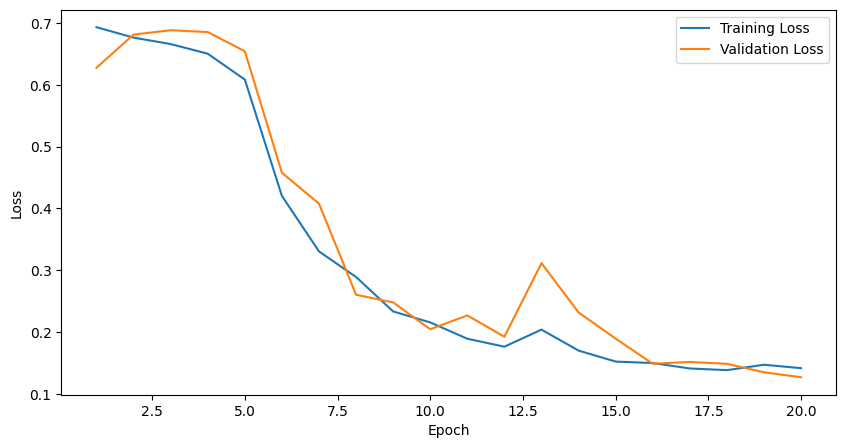

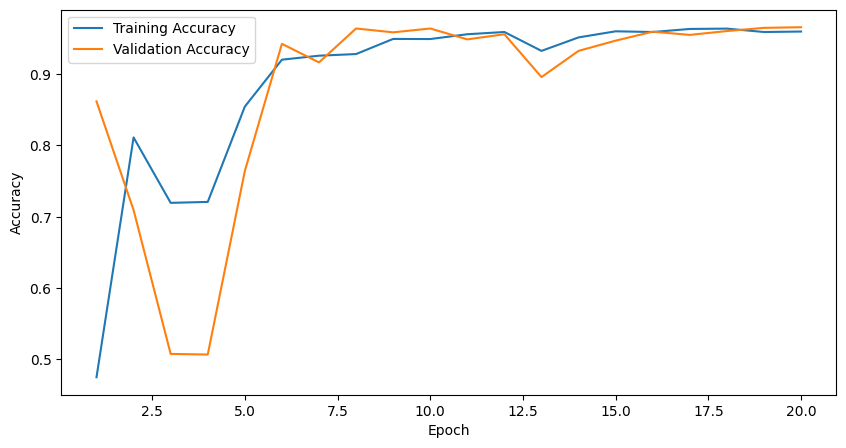

In [ ]:
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):

    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    n = 1
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            pred = model(batch.sms[0])
            loss = criterion(pred, batch.label)
            loss.backward()
            optimizer.step()

        epochs.append(n)
        train_loss.append(get_loss(model, train_loader, criterion))
        val_loss.append(get_loss(model, valid_loader, criterion))
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy(model, valid_loader))
        n += 1
        model.eval()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_acc[-1]:.4f}, Valid Accuracy: {val_acc[-1]:.4f}')
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'model_{epoch}.pt')

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def get_loss(model, data_loader, criterion):
    total_loss = 0

    for batch in data_loader:
        out = model(batch.sms[0].clone())
        loss = criterion(out, batch.label)
        total_loss += loss.item()
    return total_loss / len(data_loader)

model = MyRNN(len(text_field.vocab.itos), 30, 2)

val_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

train(model, train_iter, val_iter, num_epochs=20)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**Model 1: Tuning number of hidden units** \\
Increasing hidden units from 30 to 80

Train Accuracy: 0.9701

Validation Accuracy 0.9534

Epoch [1/20], Train Accuracy: 0.6193, Valid Accuracy: 0.3291
Epoch [2/20], Train Accuracy: 0.8965, Valid Accuracy: 0.9677
Epoch [3/20], Train Accuracy: 0.9352, Valid Accuracy: 0.9139
Epoch [4/20], Train Accuracy: 0.9243, Valid Accuracy: 0.9686
Epoch [5/20], Train Accuracy: 0.9483, Valid Accuracy: 0.9139
Epoch [6/20], Train Accuracy: 0.9510, Valid Accuracy: 0.9166
Epoch [7/20], Train Accuracy: 0.9349, Valid Accuracy: 0.9686
Epoch [8/20], Train Accuracy: 0.9541, Valid Accuracy: 0.9686
Epoch [9/20], Train Accuracy: 0.9615, Valid Accuracy: 0.9578
Epoch [10/20], Train Accuracy: 0.9620, Valid Accuracy: 0.9713
Epoch [11/20], Train Accuracy: 0.9653, Valid Accuracy: 0.9587
Epoch [12/20], Train Accuracy: 0.9650, Valid Accuracy: 0.9552
Epoch [13/20], Train Accuracy: 0.9375, Valid Accuracy: 0.8825
Epoch [14/20], Train Accuracy: 0.9668, Valid Accuracy: 0.9659
Epoch [15/20], Train Accuracy: 0.9592, Valid Accuracy: 0.9767
Epoch [16/20], Train Accuracy: 0.9633, Valid Accuracy: 0.9336
Epoch [17/20], Tr

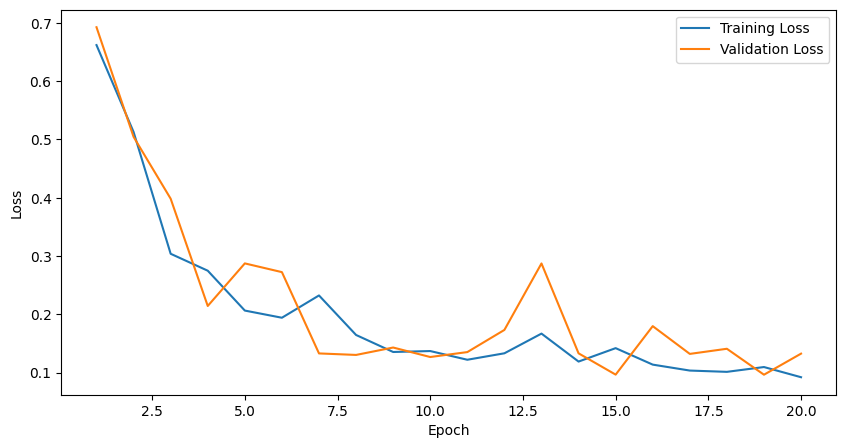

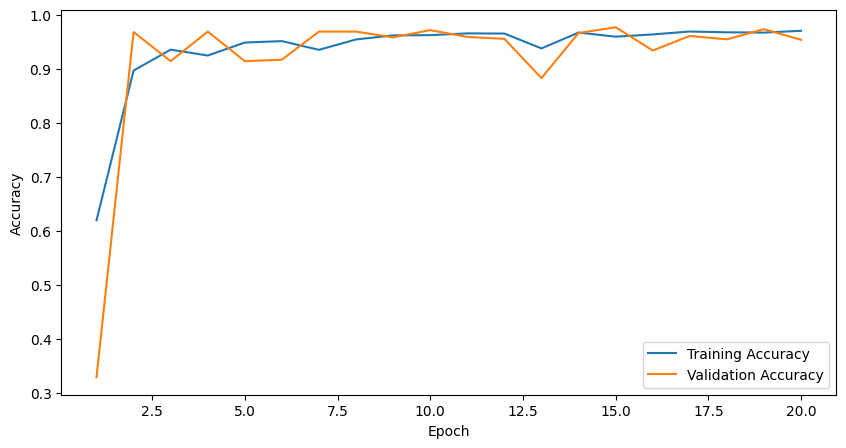

In [ ]:
model1 = MyRNN(len(text_field.vocab.itos), 80, 2)
train(model1, train_iter, val_iter, num_epochs=20)

**Model 2: Tuning learning rate** \\
Increasing learning rate from 1e-4 to 1e-3

Train Accuracy: 0.9933

Validation Accuracy: 0.9722

Epoch [1/20], Train Accuracy: 0.9464, Valid Accuracy: 0.9570
Epoch [2/20], Train Accuracy: 0.9460, Valid Accuracy: 0.9713
Epoch [3/20], Train Accuracy: 0.9543, Valid Accuracy: 0.9695
Epoch [4/20], Train Accuracy: 0.9627, Valid Accuracy: 0.9543
Epoch [5/20], Train Accuracy: 0.9521, Valid Accuracy: 0.9731
Epoch [6/20], Train Accuracy: 0.9673, Valid Accuracy: 0.9632
Epoch [7/20], Train Accuracy: 0.9687, Valid Accuracy: 0.9713
Epoch [8/20], Train Accuracy: 0.9734, Valid Accuracy: 0.9695
Epoch [9/20], Train Accuracy: 0.9702, Valid Accuracy: 0.9713
Epoch [10/20], Train Accuracy: 0.9681, Valid Accuracy: 0.9731
Epoch [11/20], Train Accuracy: 0.9817, Valid Accuracy: 0.9677
Epoch [12/20], Train Accuracy: 0.9844, Valid Accuracy: 0.9722
Epoch [13/20], Train Accuracy: 0.9852, Valid Accuracy: 0.9668
Epoch [14/20], Train Accuracy: 0.9852, Valid Accuracy: 0.9596
Epoch [15/20], Train Accuracy: 0.9834, Valid Accuracy: 0.9767
Epoch [16/20], Train Accuracy: 0.9857, Valid Accuracy: 0.9749
Epoch [17/20], Tr

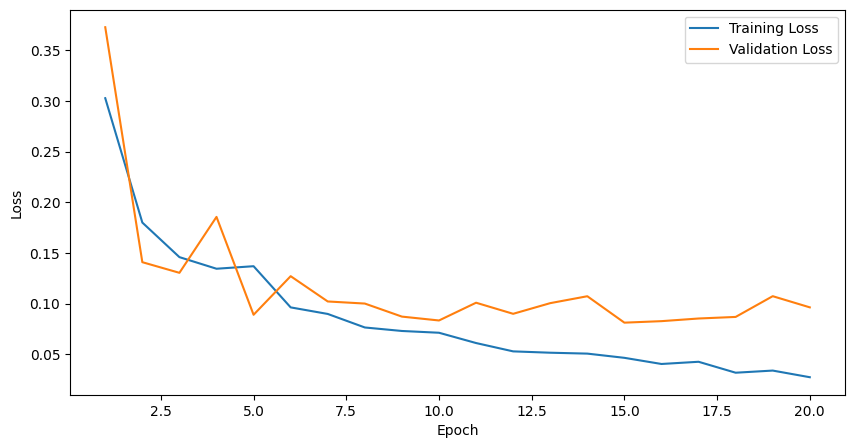

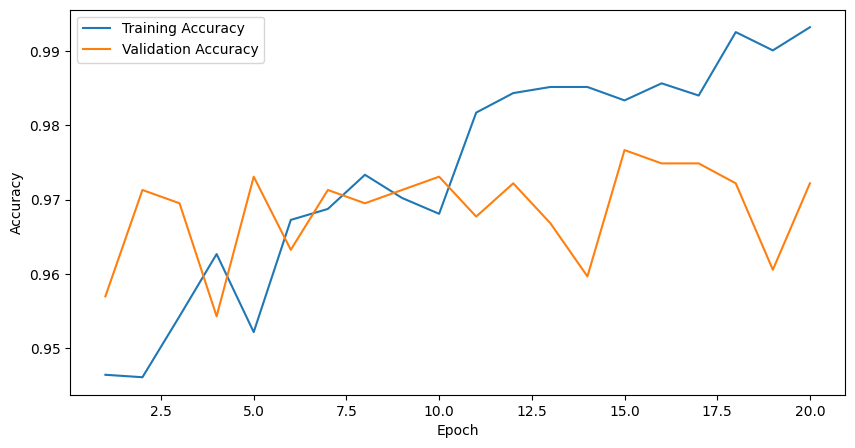

In [ ]:
model2 = MyRNN(len(text_field.vocab.itos), 30, 2)
train(model2, train_iter, val_iter, num_epochs=20, learning_rate=1e-3)

**Model 3: Max pooling over entire output array, NO CONCATENATION** \\
Adjusting model architecture by removing concatenation before output.

Train Accuracy: 0.9582

Validation Accuracy: 0.9605

Epoch [1/20], Train Accuracy: 0.5251, Valid Accuracy: 0.1381
Epoch [2/20], Train Accuracy: 0.5251, Valid Accuracy: 0.1381
Epoch [3/20], Train Accuracy: 0.5256, Valid Accuracy: 0.1399
Epoch [4/20], Train Accuracy: 0.5753, Valid Accuracy: 0.2197
Epoch [5/20], Train Accuracy: 0.8617, Valid Accuracy: 0.7973
Epoch [6/20], Train Accuracy: 0.8860, Valid Accuracy: 0.8556
Epoch [7/20], Train Accuracy: 0.9294, Valid Accuracy: 0.9570
Epoch [8/20], Train Accuracy: 0.9354, Valid Accuracy: 0.9623
Epoch [9/20], Train Accuracy: 0.9390, Valid Accuracy: 0.9471
Epoch [10/20], Train Accuracy: 0.9401, Valid Accuracy: 0.9641
Epoch [11/20], Train Accuracy: 0.9432, Valid Accuracy: 0.9632
Epoch [12/20], Train Accuracy: 0.9472, Valid Accuracy: 0.9552
Epoch [13/20], Train Accuracy: 0.9533, Valid Accuracy: 0.9596
Epoch [14/20], Train Accuracy: 0.9534, Valid Accuracy: 0.9605
Epoch [15/20], Train Accuracy: 0.9539, Valid Accuracy: 0.9614
Epoch [16/20], Train Accuracy: 0.9539, Valid Accuracy: 0.9587
Epoch [17/20], Tr

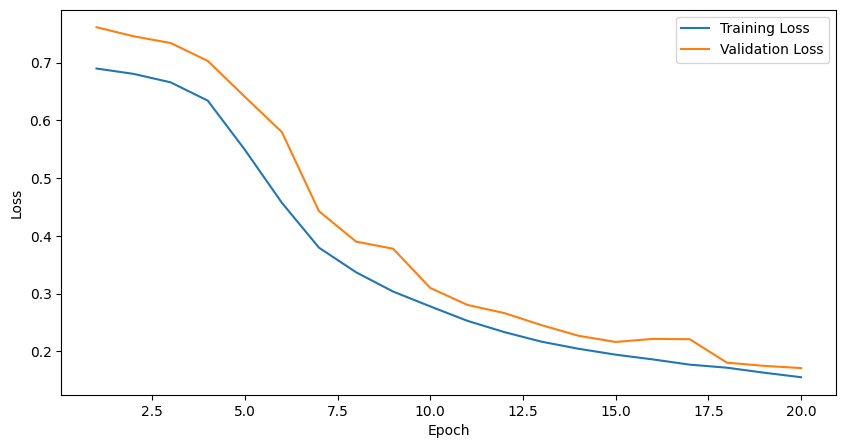

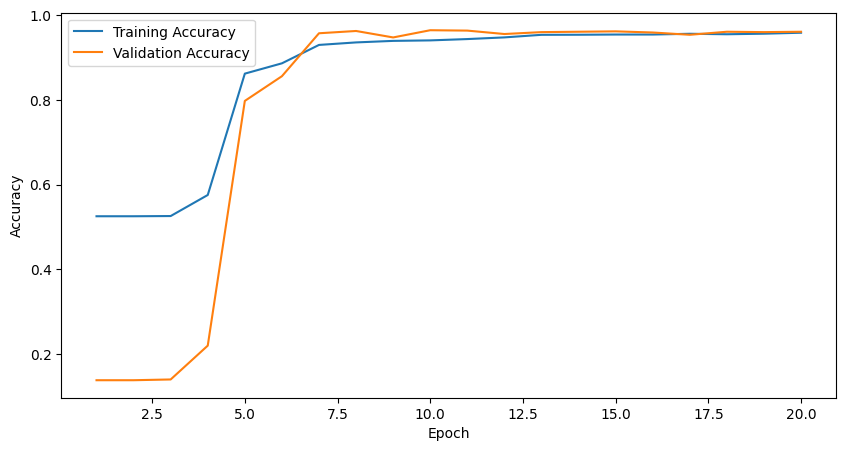

In [ ]:
class MyRNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(MyRNN_2, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)
    def forward(self, x):
        x = nn.functional.embedding(x, self.emb)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = torch.max(out, dim=1)[0]
        return self.fc(out)

model3 = MyRNN_2(len(text_field.vocab.itos), 30, 2)
train(model3, train_iter, val_iter, num_epochs=20)

**Model 4: Use a GRU architecture** \\
Adjusting model architecture by switching from classic `nn.RNN` to `nn.GRU`

Train Accuracy: 0.9553

Validation Accuracy: 0.9677

Epoch [1/20], Train Accuracy: 0.4749, Valid Accuracy: 0.8619
Epoch [2/20], Train Accuracy: 0.9169, Valid Accuracy: 0.9067
Epoch [3/20], Train Accuracy: 0.6776, Valid Accuracy: 0.4063
Epoch [4/20], Train Accuracy: 0.8337, Valid Accuracy: 0.6978
Epoch [5/20], Train Accuracy: 0.9222, Valid Accuracy: 0.9722
Epoch [6/20], Train Accuracy: 0.9354, Valid Accuracy: 0.9731
Epoch [7/20], Train Accuracy: 0.9411, Valid Accuracy: 0.9677
Epoch [8/20], Train Accuracy: 0.9411, Valid Accuracy: 0.9722
Epoch [9/20], Train Accuracy: 0.9395, Valid Accuracy: 0.9686
Epoch [10/20], Train Accuracy: 0.9451, Valid Accuracy: 0.9668
Epoch [11/20], Train Accuracy: 0.9446, Valid Accuracy: 0.9704
Epoch [12/20], Train Accuracy: 0.9464, Valid Accuracy: 0.9695
Epoch [13/20], Train Accuracy: 0.9416, Valid Accuracy: 0.9722
Epoch [14/20], Train Accuracy: 0.9506, Valid Accuracy: 0.9704
Epoch [15/20], Train Accuracy: 0.9490, Valid Accuracy: 0.9713
Epoch [16/20], Train Accuracy: 0.9497, Valid Accuracy: 0.9704
Epoch [17/20], Tr

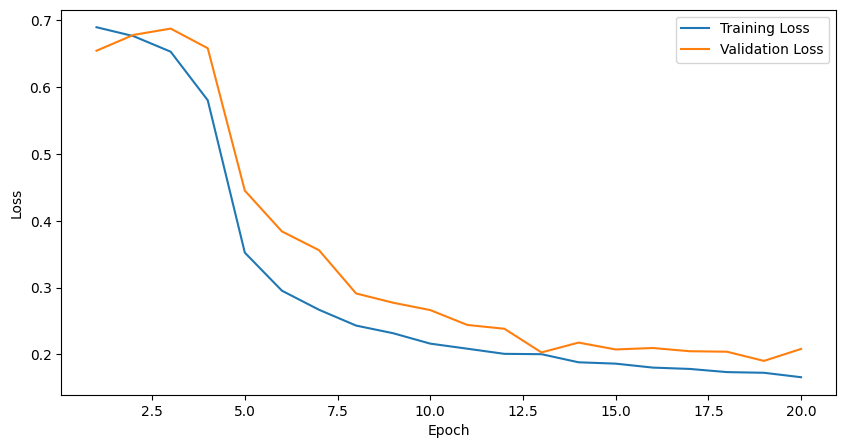

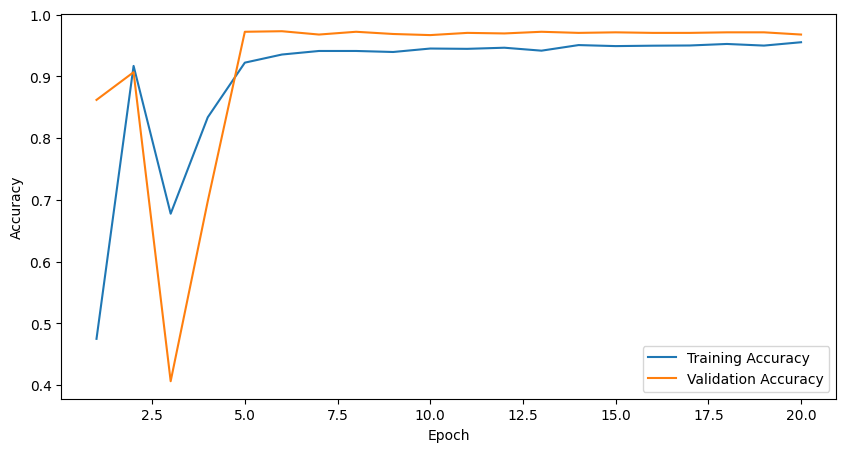

In [ ]:
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(MyGRU, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_class)
    def forward(self, x):
        x = torch.nn.functional.embedding(x, self.emb)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, __ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

model4 = MyGRU(len(text_field.vocab.itos), 30, 2)
train(model4, train_iter, val_iter, num_epochs=20)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

val_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print('False negative rate: ', 1 - get_accuracy(model2, val_spam_iter))
print('False positive rate: ', 1 - get_accuracy(model2, val_nospam_iter))

False negative rate:  0.11038961038961037
False positive rate:  0.014568158168574374


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false negative prediction would mean we classify a spam message as a non spam message. This is not ideal, but there would be no significant impact --  a spam message simply got through. A false positive prediction would mean that we classify a non spam message as a spam message. This is more impactful because by classifying a non spam message as a spam message we run the risk of potentially disregarding an important message for us.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print('Test accuracy: ', get_accuracy(model, test_iter))

Test accuracy:  0.9703770197486535


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print('False negative rate: ', 1 - get_accuracy(model2, test_spam_iter))
print('False positive rate: ', 1 - get_accuracy(model2, test_nospam_iter))

False negative rate:  0.08029197080291972
False positive rate:  0.022517911975434957


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

indices = [text_field.vocab.stoi[char] for char in msg]
input = torch.tensor(indices).unsqueeze(0)

with torch.no_grad():
    output = model4(input)
    probabilties = F.sigmoid(output)
    prob_spam = probabilties[0][1].item()

print('Probability that the SMS message "machine learning is sooo cool!" is spam: ', 100*prob_spam, '%')

Probability that the SMS message "machine learning is sooo cool!" is spam:  27.36964523792267 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I believe that detecting spam can be a fairly hard task, as spam texts can most definately be edited by the sender to bypass a spam detection software, ie. by using certain keywords, punctuation, phrases or spelling.

Our model achieved a false negative rate of 8%, meaning that 8% of spam messages were classified as non spam. This is a significant error rate, as having 8% of messages not identified as spam could be problematic on a large scale (ie, with millions of spam/no spam messages incoming).

A simple baseline model can be created by obtaining a running sum of glove embedding scores, then passing the score into a fully connected network, with two output neurons whose values are passed through a sigmoid function (probability of spam/no spam).

1. Preprocess data by ensuring messages are labelled, there is an even split of spam/no spam messages, converting all text to lowercase, removing punctuation and removing stopwords.

2. Iterate through each word in the sequence. Obtain the glove embedding score for each word and create a running sum of glove embedding scores for each word in the text.

3. Pass this scalar cumulative score into a fully connected layer(s) for classification.

4. Train the model, tune hyperparameters such as number of epochs, learning rate etc.

5. Test model accuracy.

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab5_Spam_Detection.ipynb"

[NbConvertApp] Converting notebook /content/Lab5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 1161225 bytes to /content/Lab5_Spam_Detection.html
